# Finding the Greater-Than Circuit Using EAP(-IG)

First, we import various packages.

In [1]:
from functools import partial

import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import PreTrainedTokenizer
from transformer_lens import HookedTransformer

from sae_eap.eap.graph import Graph
from sae_eap.eap.evaluate_graph import evaluate_graph, evaluate_baseline
from sae_eap.eap.attribute_mem import attribute 

/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset and Metrics

This package expects data to come from a dataloader. Each item consists of clean and corrupted paired inputs (strings), as well as a label (encoded as a token id). For convenience, we've included a dataset in that form as a CSV (more to come with the full code of the paper).

A metric takes in the model's (possibly corrupted) logits, clean logits, input lengths, and labels. It computes a metric value for each batch item; this can either be used as is, or turned into a loss (lower is better), or meaned.

In [2]:
def collate_EAP(xs):
    clean, corrupted, labels = zip(*xs)
    clean = list(clean)
    corrupted = list(corrupted)
    return clean, corrupted, labels

class EAPDataset(Dataset):
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)

    def __len__(self):
        return len(self.df)
    
    def shuffle(self):
        self.df = self.df.sample(frac=1)

    def head(self, n: int):
        self.df = self.df.head(n)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return row['clean'], row['corrupted'], row['label']
    
    def to_dataloader(self, batch_size: int):
        return DataLoader(self, batch_size=batch_size, collate_fn=collate_EAP)
    
def get_logit_positions(logits: torch.Tensor, input_length: torch.Tensor):
    batch_size = logits.size(0)
    idx = torch.arange(batch_size, device=logits.device)

    logits = logits[idx, input_length - 1]
    return logits

def get_prob_diff(tokenizer: PreTrainedTokenizer):
    year_indices = torch.tensor([tokenizer(f'{year:02d}').input_ids[0] for year in range(100)])

    def prob_diff(logits: torch.Tensor, clean_logits: torch.Tensor, input_length: torch.Tensor, labels: torch.Tensor, mean=True, loss=False):
        logits = get_logit_positions(logits, input_length)
        probs = torch.softmax(logits, dim=-1)[:, year_indices]

        results = []
        for prob, year in zip(probs, labels):
            results.append(prob[year + 1 :].sum() - prob[: year + 1].sum())
    
        results = torch.stack(results)
        if loss:
            results = -results
        if mean: 
            results = results.mean()
        return results
    return prob_diff

def kl_div(logits: torch.Tensor, clean_logits: torch.Tensor, input_length: torch.Tensor, labels: torch.Tensor, mean=True, loss=True):
    logits = get_logit_positions(logits, input_length)
    clean_logits = get_logit_positions(clean_logits, input_length)

    probs = torch.softmax(logits, dim=-1)
    clean_probs = torch.softmax(clean_logits, dim=-1)

    results = F.kl_div(probs.log(), clean_probs.log(), log_target=True, reduction='none').mean(-1)
    return results.mean() if mean else results


## Performing EAP-IG

First, we load the model, data, and metric.

In [3]:
model_name = 'gpt2-small'
model = HookedTransformer.from_pretrained(model_name, device='cuda')
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

ds = EAPDataset('greater_than_data.csv')
dataloader = ds.to_dataloader(12)
prob_diff = get_prob_diff(model.tokenizer)

/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [14]:
# Instantiate a graph with a model
g = Graph.from_model(model)
print(g.count_included_edges())

32491


Then, we perform EAP! We instantiate an unscored graph from the model, and use the attribute method to score it. This requires a model, graph, dataloader, and loss. `integrated_gradients` controls the number of iterations used; if it is set to None, we perform vanilla EAP.

In [15]:
# Attribute using the model, graph, clean / corrupted data and labels, as well as a metric
attribute(model, g, dataloader, partial(prob_diff, loss=True, mean=True), integrated_gradients=5)

100%|██████████| 32491/32491 [00:00<00:00, 1292449.15it/s]


In [16]:
print(g.count_included_edges())

32491


We can now apply greedy search to the scored graph to find a circuit! We prune dead nodes, and export the circuit.

In [17]:
g.apply_greedy(200)
print(g.count_included_edges())

200


In [18]:
g.prune_dead_nodes()
print(g.count_included_edges())
g.to_json("graph.json")

190


We can then convert our circuit into a visualization!

In [6]:
gz = g.to_graphviz()
gz.draw('graph.png', prog='dot')

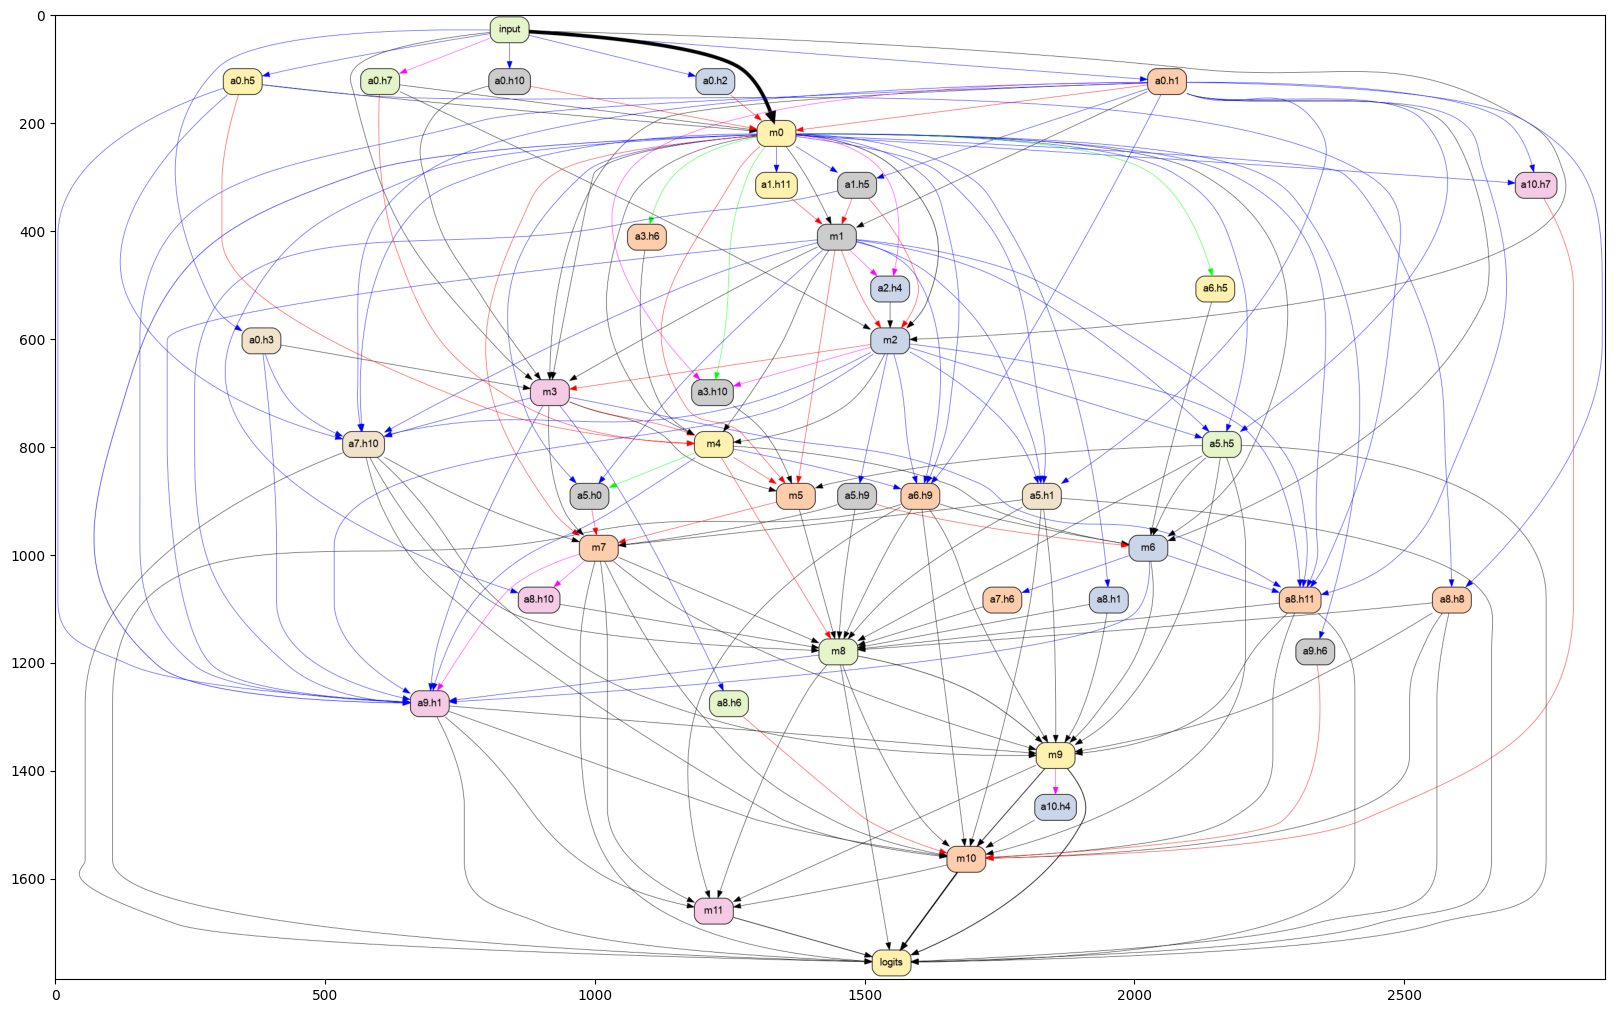

In [19]:
# Load graph.png and display
from matplotlib import pyplot as plt
from PIL import Image

img = Image.open("graph.png")
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(img)

We then evaluate our model's metric score as opposed to a baseline.

In [7]:
baseline = evaluate_baseline(model, dataloader, partial(prob_diff, loss=False, mean=False)).mean().item()
results = evaluate_graph(model, g, dataloader, partial(prob_diff, loss=False, mean=False)).mean().item()
print(f"Original performance was {baseline}; the circuit's performance is {results}")

100%|██████████| 84/84 [00:28<00:00,  2.96it/s]

Original performance was 0.8143221139907837; the circuit's performance is 0.7321222424507141


We can now compare that to a circuit found with vanilla EAP.

In [8]:
# Instantiate a graph with a model
g_eap = Graph.from_model(model)

# Attribute using the model, graph, clean / corrupted data and labels, as well as a metric
attribute(model, g_eap, dataloader, partial(prob_diff, loss=True, mean=True), integrated_gradients=None)

g_eap.apply_greedy(200)
g_eap.prune_dead_nodes()

baseline_eap = evaluate_baseline(model, dataloader, partial(prob_diff, loss=False, mean=False)).mean().item()
results_eap = evaluate_graph(model, g_eap, dataloader, partial(prob_diff, loss=False, mean=False)).mean().item()
print(f"Original performance was {baseline_eap}; the circuit's performance is {results_eap}")

100%|██████████| 84/84 [00:30<00:00,  2.77it/s]

Original performance was 0.8143221139907837; the circuit's performance is 0.6663447618484497
